## Import dataset, split it in `heart_target` and `heart_data`

Furthermore, look at the distribution of outcome values

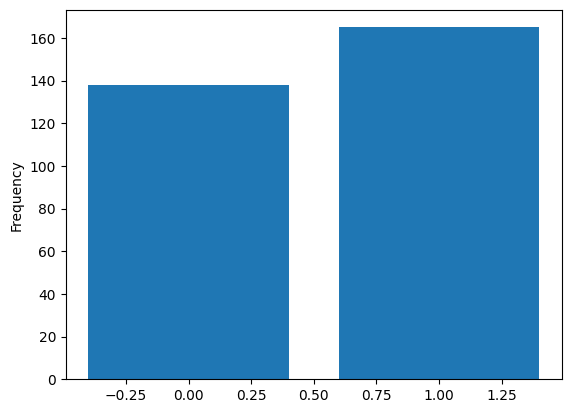

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

heart = pd.read_csv("data/raw_dataset/heart.csv")

from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt

# separate the target variable from the features
heart_target = heart['output']
heart_data = heart.drop('output', axis=1)

# plot the class distribution
class_dist = pd.Series(heart_target).value_counts()
plt.bar(class_dist.index, class_dist)
plt.ylabel("Frequency")
plt.show()

display(heart_data.head())
display(heart_data.describe())


## Visualize the distribution of attributes

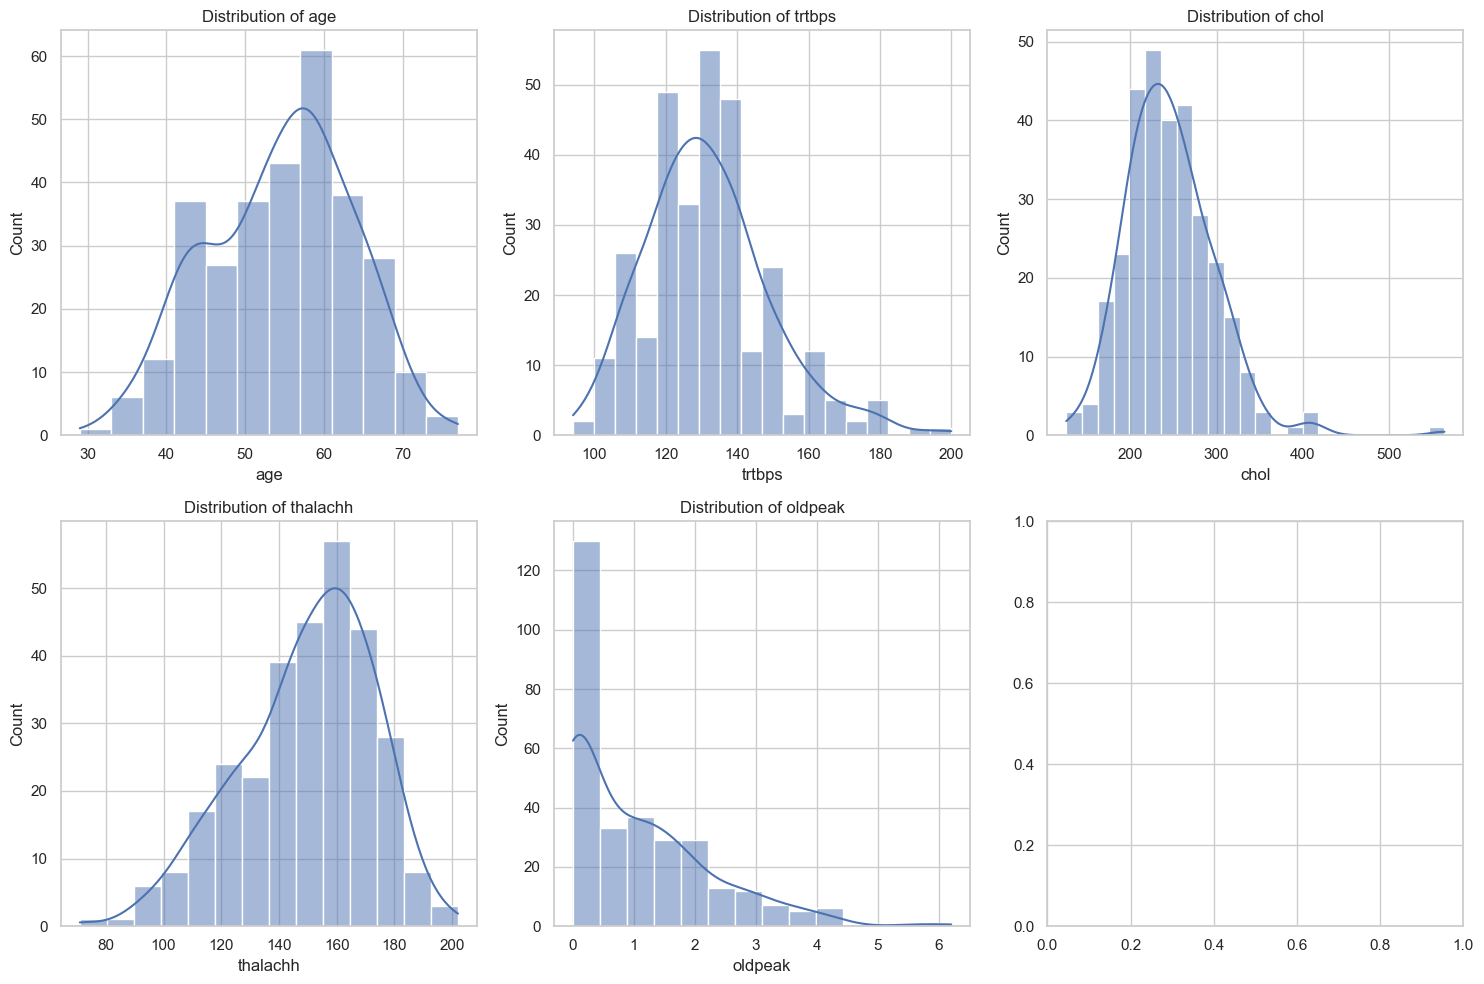

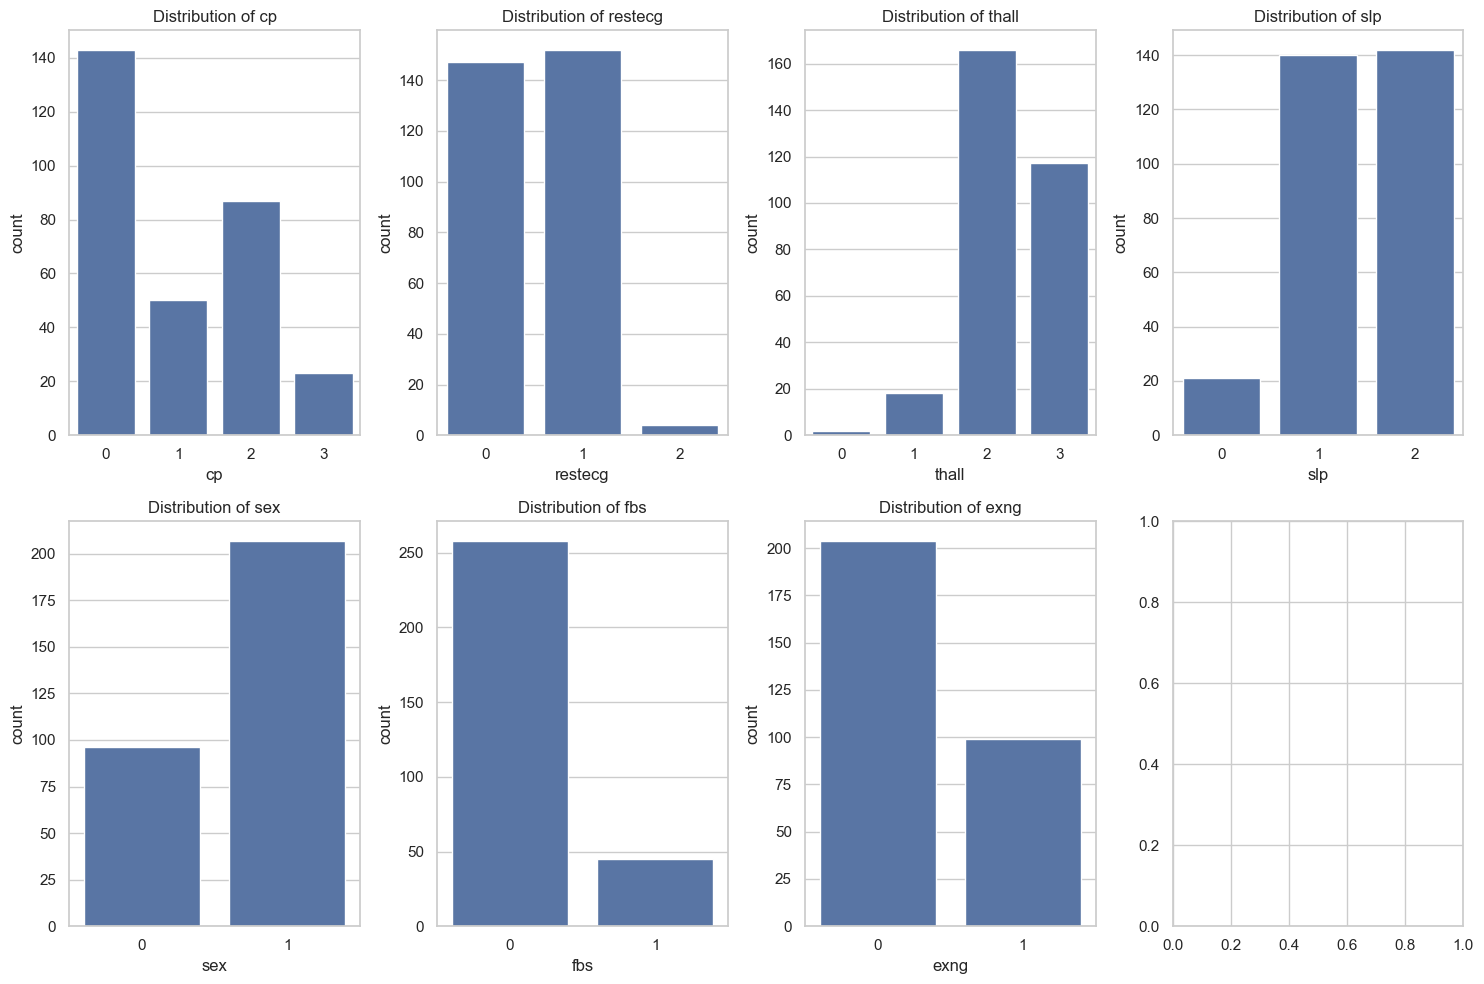

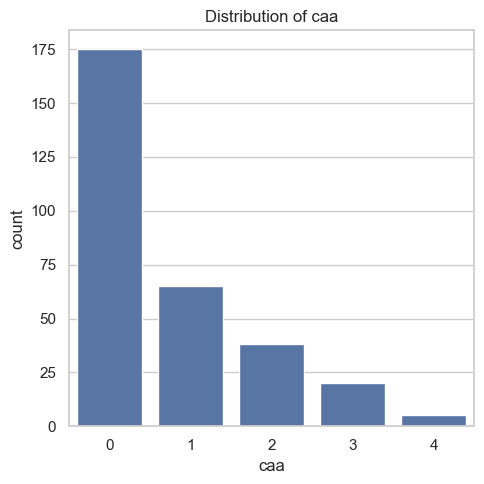

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# numerical features
numeric_features = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']

# categorical features
categorical_features = ['cp', 'restecg', 'thall', 'slp', 'sex', 'fbs', 'exng']

# ordinal features
ordinal_features = ['caa']

# Set the style of seaborn
sns.set(style="whitegrid")

# subplots for numerical features
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    sns.histplot(heart_data[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

# subplots for categorical features
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    sns.countplot(x=feature, data=heart_data, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

# subplot for ordinal features
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

sns.countplot(x='caa', data=heart_data, ax=ax)
ax.set_title(f'Distribution of caa')

plt.tight_layout()
plt.show()


## Measure the correlation between attributes and the outcome:

-> Especially `fbs` and `trtbps` don't seem to play a big role for the outcome

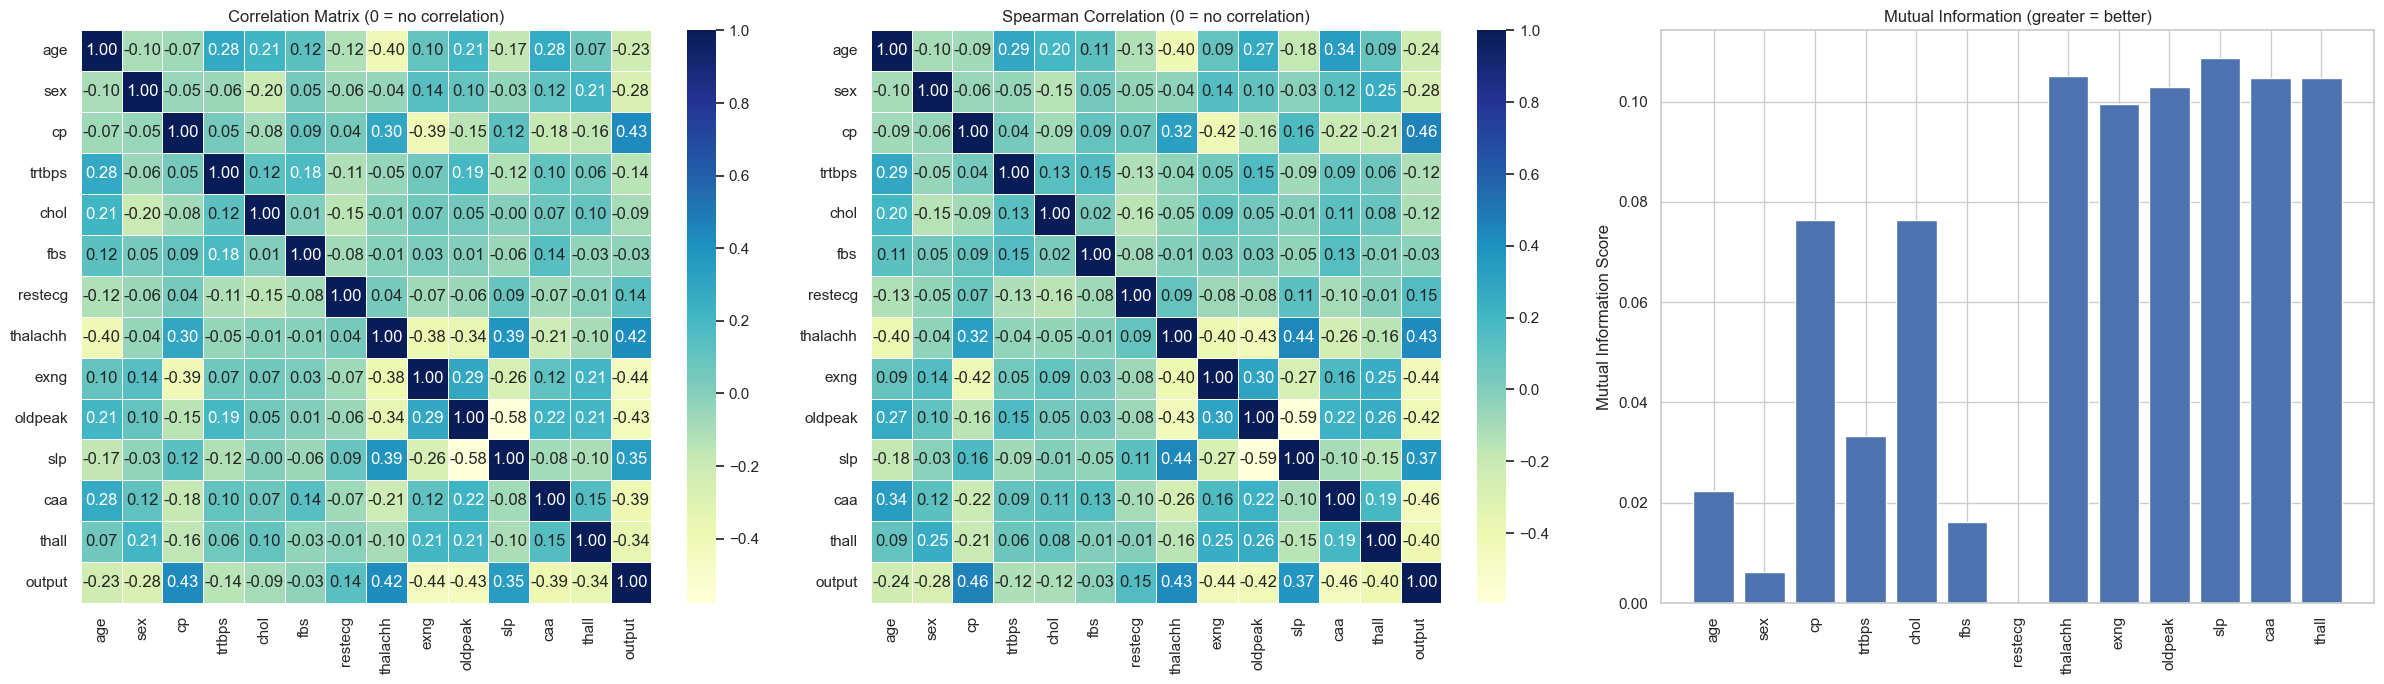

In [3]:
from sklearn.feature_selection import mutual_info_regression

# Correlation matrix
corr_matrix = heart.corr()

# Spearman correlation
spearman_corr = heart.corr(method='spearman')

# Mutual Information
mutual_info = mutual_info_regression(heart_data, heart_target)
mutual_info = pd.Series(mutual_info)
mutual_info.index = heart_data.columns


# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(24, 7))

# Plot correlation matrix
sns.heatmap(corr_matrix, 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f", 
            cmap="YlGnBu", 
            ax=axs[0])
axs[0].set_title('Correlation Matrix (0 = no correlation)')

# Plot Spearman correlation
sns.heatmap(spearman_corr, 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f", 
            cmap="YlGnBu", 
            ax=axs[1])
axs[1].set_title('Spearman Correlation (0 = no correlation)')

# Plot Mutual Information
axs[2].bar(mutual_info.index, mutual_info)
plt.xticks(rotation=90)
axs[2].set_ylabel('Mutual Information Score')
axs[2].set_title('Mutual Information (greater = better)')

plt.tight_layout()
plt.show()

## Preprocessing using a pipeline and a **`RandomForestClassifier()`**:

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
# from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, accuracy_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Prepare the transformers
numeric_transformer = Pipeline([ ('scaler', StandardScaler()) ])
categorical_transformer = Pipeline([ ('onehot', OneHotEncoder()) ])
ordinal_transformer = Pipeline([ ('ordinal', OrdinalEncoder()) ])

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features)])

print("Scaled data:")
display(preprocessor.fit_transform(heart_data))

pipeline = Pipeline([ 
    ('preprocessing', preprocessor), 
    # ('balancing', RandomOverSampler()), # No over sampler
    ('estimator', RandomForestClassifier(random_state=42)) ])

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


Scaled data:


array([[ 0.9521966 ,  0.76395577, -0.25633371, ...,  1.        ,
         0.        ,  0.        ],
       [-1.91531289, -0.09273778,  0.07219949, ...,  1.        ,
         0.        ,  0.        ],
       [-1.47415758, -0.09273778, -0.81677269, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 1.50364073,  0.70684287, -1.029353  , ...,  1.        ,
         0.        ,  2.        ],
       [ 0.29046364, -0.09273778, -2.2275329 , ...,  0.        ,
         1.        ,  1.        ],
       [ 0.29046364, -0.09273778, -0.19835726, ...,  1.        ,
         0.        ,  1.        ]])

## First prediction without parameter optimization:

In [5]:
prediction = cross_val_predict(pipeline, heart_data, heart_target, cv=cv)

def cost_function(y_true, y_pred): 
    cm = confusion_matrix(y_true, y_pred)
    return cm[0][1] * 100 + cm[1][0] * 1

cm = confusion_matrix(heart_target, prediction)
cost = cost_function(heart_target, prediction)
acc = accuracy_score(heart_target, prediction)

print("Decision Tree with accuracy of {} and cost {}".format(acc, cost))
print(cm)
print(classification_report(heart_target, prediction))

Decision Tree with accuracy of 0.834983498349835 and cost 2921
[[109  29]
 [ 21 144]]
              precision    recall  f1-score   support

           0       0.84      0.79      0.81       138
           1       0.83      0.87      0.85       165

    accuracy                           0.83       303
   macro avg       0.84      0.83      0.83       303
weighted avg       0.84      0.83      0.83       303


## Default Parameters for Decision Tree:

In [5]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## Now, find the best params:

Decision Tree with accuracy of 0.83, cost 3219 and recall of 0.88
              precision    recall  f1-score   support

           0       0.85      0.77      0.81       138
           1       0.82      0.88      0.85       165

    accuracy                           0.83       303
   macro avg       0.83      0.83      0.83       303
weighted avg       0.83      0.83      0.83       303


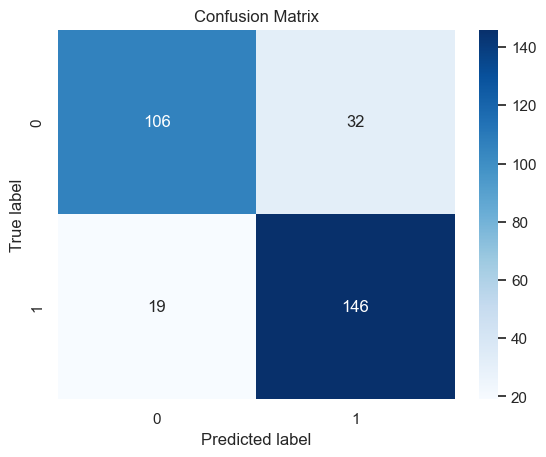

Optimised Parameters: {'estimator__criterion': 'entropy', 'estimator__max_depth': 14, 'estimator__min_samples_split': 2}


In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# define the parameter grid
parameters = {
    'estimator__criterion':['gini', 'entropy'], 
    'estimator__max_depth':[ 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, None],
    'estimator__min_samples_split' :[2,3,4,5,6,7,8,9,10]
}

# define the folds for the cross validation
stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# create a scorer for the grid search
cost_score = make_scorer(cost_function, greater_is_better=False)

# create the grid search estimator
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=cost_score, cv=stratified_10_fold_cv)

# cross-validate
prediction = cross_val_predict(grid_search_estimator, heart_data, heart_target, cv=cv, n_jobs=-1)

# calculate costs
cm = confusion_matrix(heart_target, prediction)
cost = cost_function(heart_target, prediction)
acc = accuracy_score(heart_target, prediction)
recall = recall_score(heart_target, prediction)

print("Decision Tree with accuracy of {}, cost {} and recall of {}".format(acc.round(2), cost, recall.round(2)))
print(classification_report(heart_target, prediction))

sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# fit the grid search (= determine the optimal parameters)
grid_search_estimator.fit(heart_data, heart_target)
print("Optimised Parameters: {}".format(grid_search_estimator.best_params_))

## Later, one would want to predict like that:

Decision Tree with accuracy of 0.83, cost 2624 and recall of 0.85
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       138
           1       0.84      0.85      0.85       165

    accuracy                           0.83       303
   macro avg       0.83      0.83      0.83       303
weighted avg       0.83      0.83      0.83       303


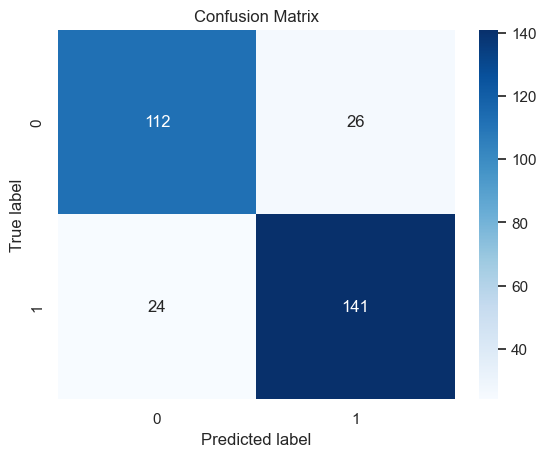

In [14]:
pipeline.set_params(
    estimator__criterion=grid_search_estimator.best_params_['estimator__criterion'],
    estimator__max_depth=grid_search_estimator.best_params_['estimator__max_depth'],
    estimator__min_samples_split=grid_search_estimator.best_params_['estimator__min_samples_split'])

prediction = cross_val_predict(pipeline, heart_data, heart_target, cv=cv)

cm = confusion_matrix(heart_target, prediction)
cost = cost_function(heart_target, prediction)
acc = accuracy_score(heart_target, prediction)
recall = recall_score(heart_target, prediction)

print("Decision Tree with accuracy of {}, cost {} and recall of {}".format(acc.round(2), cost, recall.round(2)))
print(classification_report(heart_target, prediction))

sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


## Standard Decision Tree instead of Random Forest

Decision Tree with accuracy of 0.75, cost 4135 and recall of 0.79
              precision    recall  f1-score   support

           0       0.73      0.70      0.72       138
           1       0.76      0.79      0.77       165

    accuracy                           0.75       303
   macro avg       0.75      0.75      0.75       303
weighted avg       0.75      0.75      0.75       303


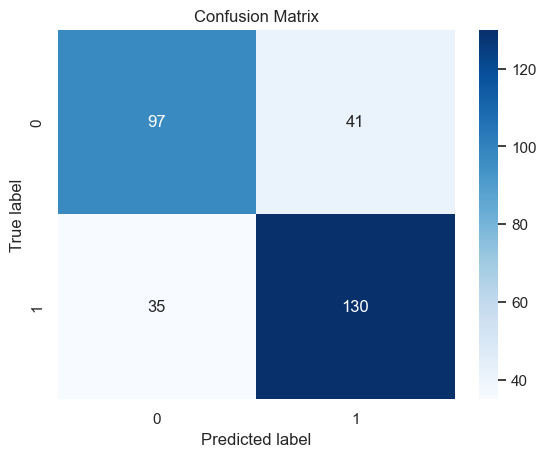

In [8]:
pipeline = Pipeline([ 
    ('preprocessing', preprocessor), 
    # ('balancing', RandomOverSampler()), # No over sampler
    ('estimator', DecisionTreeClassifier(random_state=42)) ])

prediction = cross_val_predict(pipeline, heart_data, heart_target, cv=cv)

cm = confusion_matrix(heart_target, prediction)
cost = cost_function(heart_target, prediction)
acc = accuracy_score(heart_target, prediction)
recall = recall_score(heart_target, prediction)

print("Decision Tree with accuracy of {}, cost {} and recall of {}".format(acc.round(2), cost, recall.round(2)))
print(classification_report(heart_target, prediction))

sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

## Optimize Standard Decision Tree:

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Define the parameter grid for MLPClassifier
param_grid = {
    'estimator__criterion': ['gini', 'entropy'],
    'estimator__max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, None],
    'estimator__min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]
}

# define the folds for the cross validation
stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cost_score = make_scorer(cost_function, greater_is_better=False)

# Initialize GridSearchCV
grid_search_estimator = GridSearchCV(pipeline, param_grid, scoring=cost_score, cv=stratified_10_fold_cv)

# Fit GridSearchCV
grid_search_estimator.fit(heart_data, heart_target)

# Get the best parameters
best_params = grid_search_estimator.best_params_
print(best_params)

# Use the best model to make predictions
best_model = grid_search_estimator.best_estimator_

pipeline.set_params(
    estimator__criterion=grid_search_estimator.best_params_['estimator__criterion'],
    estimator__max_depth=grid_search_estimator.best_params_['estimator__max_depth'],
    estimator__min_samples_split=grid_search_estimator.best_params_['estimator__min_samples_split'])

{'estimator__criterion': 'entropy', 'estimator__max_depth': 10, 'estimator__min_samples_split': 5}


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'trtbps', 'chol',
                                                   'thalachh', 'oldpeak']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['cp', 'restecg', 'thall',
                                                   'slp', 'sex', 'fbs',
                                                   'exng']),
                                                 ('ord',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['caa'])])),
                ('estimator',
                 DecisionTreeClassifier(criterion='entropy', max_depth=10,
                                        min_samples_split=5,
                                        random_state=42))])

Decision Tree with accuracy of 0.77, cost 3239 and recall of 0.76
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       138
           1       0.80      0.76      0.78       165

    accuracy                           0.77       303
   macro avg       0.76      0.77      0.76       303
weighted avg       0.77      0.77      0.77       303


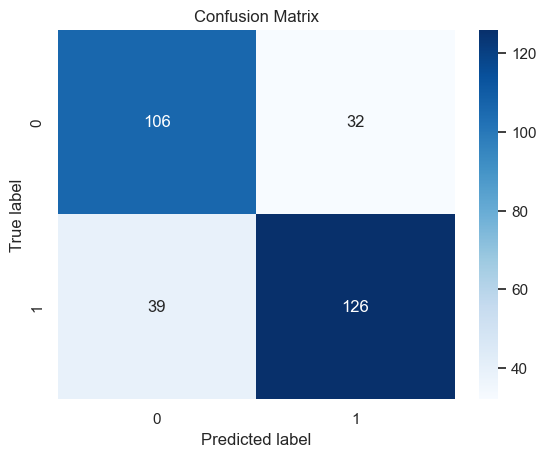

In [10]:
prediction = cross_val_predict(pipeline, heart_data, heart_target, cv=cv)

cm = confusion_matrix(heart_target, prediction)
cost = cost_function(heart_target, prediction)
acc = accuracy_score(heart_target, prediction)
recall = recall_score(heart_target, prediction)

print("Decision Tree with accuracy of {}, cost {} and recall of {}".format(acc.round(2), cost, recall.round(2)))
print(classification_report(heart_target, prediction))

sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

## Neural Network try:

In [9]:
from sklearn.neural_network import MLPClassifier

pipeline = Pipeline([ 
    ('preprocessing', preprocessor), 
    ('estimator', MLPClassifier(hidden_layer_sizes=(100,), random_state=42, max_iter=400)) ])

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Define the parameter grid for MLPClassifier
param_grid = {
    'estimator__hidden_layer_sizes': [(50,), (100,), (200,)],
    'estimator__activation': ['tanh', 'relu'],
    'estimator__solver': ['sgd', 'adam'],
    'estimator__alpha': [0.0001, 0.001, 0.01, 0.1],
    'estimator__learning_rate': ['constant','adaptive'],
}

# define the folds for the cross validation
stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cost_score = make_scorer(cost_function, greater_is_better=False)

# Initialize GridSearchCV
grid_search_estimator = GridSearchCV(pipeline, param_grid, scoring=cost_score, cv=stratified_10_fold_cv)

# Fit GridSearchCV
grid_search_estimator.fit(heart_data, heart_target)

# Get the best parameters
best_params = grid_search_estimator.best_params_
print(best_params)

# Use the best model to make predictions
best_model = grid_search_estimator.best_estimator_

pipeline.set_params(
    estimator__hidden_layer_sizes=grid_search_estimator.best_params_['estimator__hidden_layer_sizes'],
    estimator__activation=grid_search_estimator.best_params_['estimator__activation'],
    estimator__solver=grid_search_estimator.best_params_['estimator__solver'],
    estimator__alpha=grid_search_estimator.best_params_['estimator__alpha'],
    estimator__learning_rate=grid_search_estimator.best_params_['estimator__learning_rate'])

c:\Users\I573015\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\I573015\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\I573015\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\I573015\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and 

{'estimator__activation': 'relu', 'estimator__alpha': 0.0001, 'estimator__hidden_layer_sizes': (200,), 'estimator__learning_rate': 'constant', 'estimator__solver': 'sgd'}


c:\Users\I573015\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'trtbps', 'chol',
                                                   'thalachh', 'oldpeak']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['cp', 'restecg', 'thall',
                                                   'slp', 'sex', 'fbs',
                                                   'exng']),
                                                 ('ord',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['caa'])])),
                ('estimator',
                 MLPClassifier(hidden_layer_sizes=(200,), max_iter=400,
                               random_state=42, solver='sgd'))])

c:\Users\I573015\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\I573015\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\I573015\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\I573015\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and 

Decision Tree with accuracy of 0.84, cost 2722 and recall of 0.87
              precision    recall  f1-score   support

           0       0.83      0.80      0.82       138
           1       0.84      0.87      0.85       165

    accuracy                           0.84       303
   macro avg       0.84      0.84      0.84       303
weighted avg       0.84      0.84      0.84       303


c:\Users\I573015\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


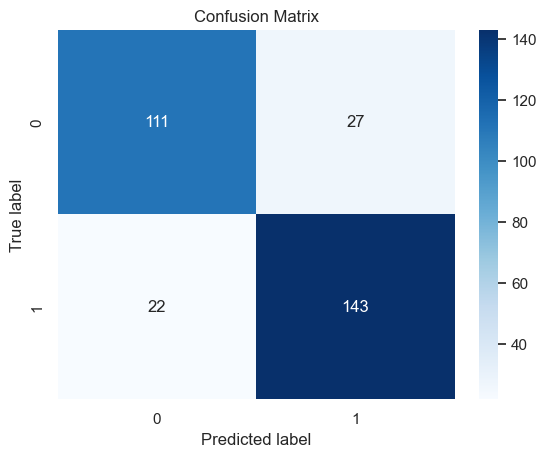

In [12]:
prediction = cross_val_predict(pipeline, heart_data, heart_target, cv=cv)

cm = confusion_matrix(heart_target, prediction)
cost = cost_function(heart_target, prediction)
acc = accuracy_score(heart_target, prediction)
recall = recall_score(heart_target, prediction)

print("Neural Network with accuracy of {}, cost {} and recall of {}".format(acc.round(2), cost, recall.round(2)))
print(classification_report(heart_target, prediction))

sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()
#

## Using Gradient Boosting Classifier

In [6]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline = Pipeline([ 
    ('preprocessing', preprocessor), 
    ('estimator', GradientBoostingClassifier(random_state=42)) ])

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Define the parameter grid for GradientBoostingClassifier
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__learning_rate': [0.01, 0.1, 1.0],
    'estimator__max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
}

cost_score = make_scorer(cost_function, greater_is_better=False)

# Initialize GridSearchCV
grid_search_estimator = GridSearchCV(pipeline, param_grid, scoring=cost_score, cv=cv)

# Fit GridSearchCV
grid_search_estimator.fit(heart_data, heart_target)

# Get the best parameters
best_params = grid_search_estimator.best_params_
print(best_params)

# Use the best model to make predictions
best_model = grid_search_estimator.best_estimator_

pipeline.set_params(
    estimator__n_estimators=grid_search_estimator.best_params_['estimator__n_estimators'],
    estimator__learning_rate=grid_search_estimator.best_params_['estimator__learning_rate'],
    estimator__max_depth=grid_search_estimator.best_params_['estimator__max_depth'])

{'estimator__learning_rate': 0.1, 'estimator__max_depth': 2, 'estimator__n_estimators': 50}


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'trtbps', 'chol',
                                                   'thalachh', 'oldpeak']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['cp', 'restecg', 'thall',
                                                   'slp', 'sex', 'fbs',
                                                   'exng']),
                                                 ('ord',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['caa'])])),
                ('estimator',
                 GradientBoostingClassifier(max_depth=2, n_estimators=50,
                                            random_state=42))])

Gradient Boosting Classifier with accuracy of 0.84, cost 2920 and recall of 0.88
              precision    recall  f1-score   support

           0       0.84      0.79      0.82       138
           1       0.83      0.88      0.86       165

    accuracy                           0.84       303
   macro avg       0.84      0.83      0.84       303
weighted avg       0.84      0.84      0.84       303


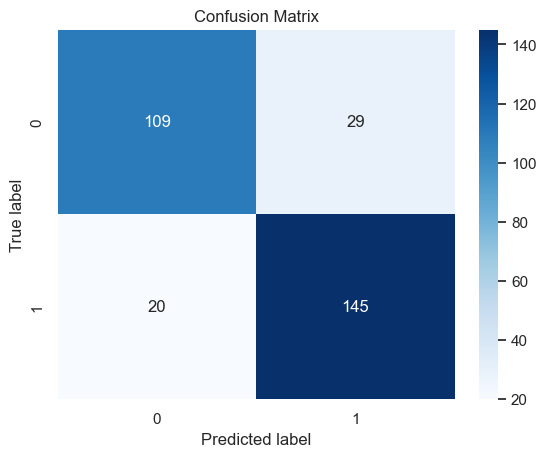

In [10]:
prediction = cross_val_predict(pipeline, heart_data, heart_target, cv=cv)

cm = confusion_matrix(heart_target, prediction)
cost = cost_function(heart_target, prediction)
acc = accuracy_score(heart_target, prediction)
recall = recall_score(heart_target, prediction)

print("Gradient Boosting Classifier with accuracy of {}, cost {} and recall of {}".format(acc.round(2), cost, recall.round(2)))
print(classification_report(heart_target, prediction))

sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()
#

## Using Support Vector Machines (SVM)

In [11]:
from sklearn.svm import SVC

pipeline = Pipeline([ 
    ('preprocessing', preprocessor), 
    ('estimator', SVC(random_state=42)) ])

In [14]:
# Define the parameter grid for SVC
param_grid = {
    'estimator__C': [0.1, 1, 10, 100, 200, 300],  # Regularization parameter
    'estimator__gamma': [1, 0.1, 0.01, 0.001],  # Kernel coefficient
    'estimator__kernel': ['rbf', 'linear', 'poly']  # Specifies the kernel type to be used in the algorithm
}

cost_score = make_scorer(cost_function, greater_is_better=False)

# Initialize GridSearchCV
grid_search_estimator = GridSearchCV(pipeline, param_grid, scoring=cost_score, cv=cv)

# Fit GridSearchCV
grid_search_estimator.fit(heart_data, heart_target)

# Get the best parameters
best_params = grid_search_estimator.best_params_
print(best_params)

# Use the best model to make predictions
best_model = grid_search_estimator.best_estimator_

pipeline.set_params(
    estimator__C=grid_search_estimator.best_params_['estimator__C'],
    estimator__gamma=grid_search_estimator.best_params_['estimator__gamma'],
    estimator__kernel=grid_search_estimator.best_params_['estimator__kernel'])

{'estimator__C': 100, 'estimator__gamma': 0.01, 'estimator__kernel': 'rbf'}


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'trtbps', 'chol',
                                                   'thalachh', 'oldpeak']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['cp', 'restecg', 'thall',
                                                   'slp', 'sex', 'fbs',
                                                   'exng']),
                                                 ('ord',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['caa'])])),
                ('estimator', SVC(C=100, gamma=0.01, random_state=42))])

Gradient Boosting Classifier with accuracy of 0.85, cost 2719 and recall of 0.88
              precision    recall  f1-score   support

           0       0.85      0.80      0.83       138
           1       0.84      0.88      0.86       165

    accuracy                           0.85       303
   macro avg       0.85      0.84      0.85       303
weighted avg       0.85      0.85      0.85       303


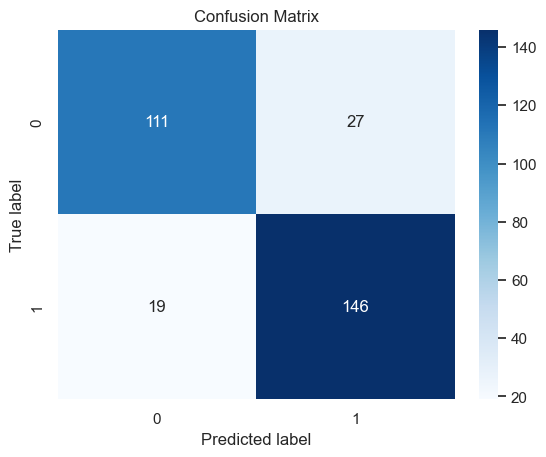

In [15]:
prediction = cross_val_predict(pipeline, heart_data, heart_target, cv=cv)

cm = confusion_matrix(heart_target, prediction)
cost = cost_function(heart_target, prediction)
acc = accuracy_score(heart_target, prediction)
recall = recall_score(heart_target, prediction)

print("Gradient Boosting Classifier with accuracy of {}, cost {} and recall of {}".format(acc.round(2), cost, recall.round(2)))
print(classification_report(heart_target, prediction))

sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()
#